# Sensors 

This notebook shows examples of sensors and navigation behaviors using them.

## Odometry

In [1]:
from navground import core, sim
from navground.sim.ui.video import display_video_from_run, record_video_from_run

In [3]:
import numpy as np

exp = sim.load_experiment("""
steps: 1000
time_step: 0.1
record_pose: true
scenario:
  groups:
    - type: thymio
      color: darkcyan
      number: 1
      radius: 0.25
      orientation: 0
      speed_tolerance: 0.1
      kinematics:
        type: 2WDiff
        max_speed: 1.0
        wheel_axis: 0.5
      behavior:
        type: Dummy
        optimal_speed: 0.5
      task:
        type: Waypoints
        waypoints: [[3, 0], [3, 3], [0, 3], [0, 0]]
        loop: false
        tolerance: 0.1
      state_estimation:
        type: Odometry
        angular_speed_bias: 0.1
        angular_speed_std_dev: 0.2
        longitudinal_speed_bias: -0.2
        longitudinal_speed_std_dev: 0.2
        transversal_speed_bias: 0
        transversal_speed_std_dev: 0.05
        update_ego_state: true
        update_sensing_state: false
""")

class OdomProbe(sim.RecordProbe):

    dtype = float

    def update(self, run: sim.ExperimentalRun) -> None:
        for agent in run.world.agents:
            self.data.append(np.array(agent.behavior.position))

    def get_shape(self, world: sim.World) -> list[int]:
        return [len(world.agents), 2]

exp.add_record_probe("odom/poses", OdomProbe)
        

In [7]:
run = exp.run_once(0)

In [8]:
run.records

{'odom/poses': <Dataset: shape (313, 1, 2), dtype float64>,
 'poses': <Dataset: shape (313, 1, 3), dtype float64>}

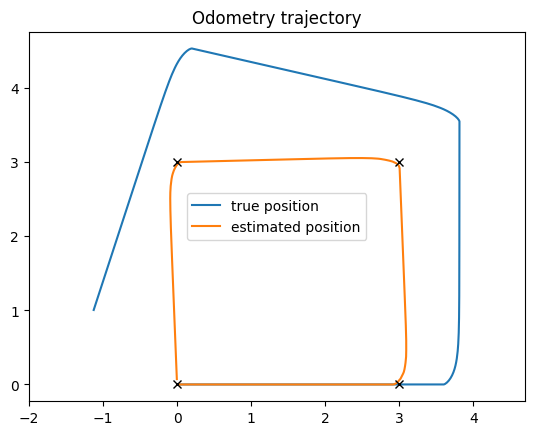

In [9]:
from matplotlib import pyplot as plt
from navground.sim.pyplot_helpers import plot_run

odom_poses = np.asarray(run.get_record("odom/poses"))

plt.plot(run.poses[:, 0, 0], run.poses[:, 0, 1], label="true position")
plt.plot(odom_poses[:, 0, 0], odom_poses[:, 0, 1], label="estimated position")
for p in run.world.agents[0].task.waypoints:
    plt.plot(*p, 'kx')
plt.legend()
plt.title("Odometry trajectory")
plt.axis('equal');

In [10]:
def render_trace(points: list[core.Vector2], color: str, width: float = 0.03, opacity: float = 0.5) -> str:
    svg_point = " ".join([f"{x:.4f},{y:.4f}" for x, y in points])
    return f'<polyline points="{svg_point}" fill="none" stroke="{color}" stroke-width="{width}" stroke-opacity="{opacity}"/>'


positions = run.poses[:, 0, :2]
odom_positions = np.asarray(run.get_record("odom/poses"))[:, 0, :2]

def render_traces(world: sim.World) -> str:
    return "\n".join([
        render_trace(positions[:world.step], color='black'),
        render_trace(odom_positions[:world.step], color='orange')])

display_video_from_run(run, factor=3, width=1280, extras=[render_traces])

In [11]:
record_video_from_run("../components/state_estimations/odometry.mp4", run, factor=3, width=1280, extras=[render_traces])

## Boundary

In [12]:
import numpy as np
from navground import core, sim

class StayAwayFromBoundary(core.Behavior, name="StayAwayFromBoundary"):

    def __init__(self, kinematics: core.Kinematics | None = None, radius: float = 0.0):
        super().__init__(kinematics, radius)
        self._state = core.SensingState()

    def get_environment_state(self) -> core.EnvironmentState:
        return self._state
    
    def desired_velocity_towards_velocity(self, velocity: core. Vector2, time_step: float) -> core.Vector2:
        d1, d2 = self._state.buffers['boundary_distance'].data
        r = self.radius + self.safety_margin
        if d1 < r or d2 < r:
            velocity[1] = 0
        return velocity

    def desired_velocity_towards_point(self, point: core.Vector2, speed: float, time_step: float) -> core.Vector2:
        delta = point - self.pose.position
        distance = np.linalg.norm(delta)
        if distance:
            return self.desired_velocity_towards_velocity(
                speed * delta / distance, time_step)
        return np.zeros(2)


In [13]:
exp = sim.load_experiment("""
steps: 200
time_step: 0.1
record_pose: true
scenario:
  bounding_box:
    min_y: 0
    max_y: 2
    min_x: -1
    max_x: 5
  groups:
    - type: thymio
      color: darkcyan
      number: 1
      radius: 0.25
      control_period: 0.1
      orientation: 0
      position: [0, 0.5]
      kinematics:
        type: 2WDiff
        max_speed: 1.0
        wheel_axis: 0.5
      behavior:
        type: StayAwayFromBoundary
        optimal_speed: 0.25
        safety_margin: 0.1
      task: 
        type: Direction
        direction: [1, 1]
      state_estimation:
        type: Boundary
        min_y: 0
        max_y: 2
""")

In [14]:
run = exp.run_once(0)

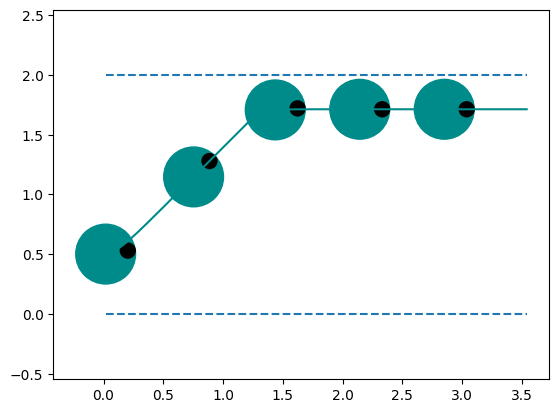

In [15]:
from matplotlib import pyplot as plt
from navground.sim.pyplot_helpers import plot_run

ax = plt.subplot()
bb = run.world.bounding_box

ax.hlines([bb.min_y, bb.max_y], min(run.poses[..., 0]), max(run.poses[..., 0]), linestyle="dashed")
plot_run(ax, run=run, step=40, with_agent=True)
plt.axis('equal');

In [16]:
run.world.bounding_box

BoundingBox(min_x=-1.0, max_x=5.0, min_y=0.0, max_y=2.0)

In [17]:
def render_boundary(world: sim.World) -> str:
    s = ''
    x1 = world.bounding_box.min_x
    x2 = world.bounding_box.max_x
    for y in (world.bounding_box.min_y, world.bounding_box.max_y):
        s += f'<line x1="{x1}" y1="{y}" x2="{x2}" y2="{y}" stroke="blue" stroke-width="0.01" stroke-dasharray="0.1" />'
    return s

In [18]:
display_video_from_run(run, factor=3, width=1280, extras=[render_boundary])

In [213]:
record_video_from_run("../components/state_estimations/boundary.mp4", run, factor=3, width=1280, extras=[render_boundary])

## Lidar

In [19]:
import numpy as np
from navground import core, sim
import math

def distance_from_target(angle: float, free_range: float, horizon: float) -> float:
    d = math.cos(angle) * horizon
    if d < 0:
        return horizon
    if d < free_range:
        return abs(math.sin(angle) * horizon)
    return math.sqrt(horizon ** 2 + free_range ** 2 - 2 * free_range * d)


def dilate_ranges(ranges: np.ndarray, by: float, fov: float):
    d_ranges = np.array(ranges)
    for i, r in enumerate(ranges):
        alpha = math.asin(min(by / r, 1))
        di = math.ceil(alpha / fov * len(ranges))
        i0 = max(i - di, 0)
        d_ranges[i0: i + di] = np.minimum(max(0, r - by), d_ranges[i0: i + di])
    return d_ranges  


class BehaviorUsingLidar(core.Behavior, name="UsingLidar"):

    def __init__(self, kinematics: core.Kinematics | None = None, radius: float = 0.0):
        super().__init__(kinematics, radius)
        self._state = core.SensingState()
        self._eta = 0.5

    @property
    def eta(self) -> float:
        return self._eta

    def get_environment_state(self) -> core.EnvironmentState:
        return self._state
    
    def desired_velocity_towards_velocity(self, velocity: core. Vector2, time_step: float) -> core.Vector2:
        speed = np.linalg.norm(velocity)
        if speed:
            p = self.position + velocity / speed * self.horizon
            return self.desired_velocity_towards_point(p, speed, time_step)
        return np.zeros(2)  

    def desired_velocity_towards_point(self, point: core.Vector2, speed: float, time_step: float) -> core.Vector2:
        target_angle = core.orientation_of(point - self.position)
        opt_angle = 0.0
        opt_distance = self.horizon
        opt_free_range = -1.0
        ranges = self._state.buffers["range"].data
        fov = float(self._state.buffers["fov"].data[0])
        s = float(self._state.buffers["start_angle"].data[0]) + self.orientation
        angles = np.linspace(s, s + fov, len(ranges))
        ranges = dilate_ranges(ranges, self.radius + self.safety_margin, fov)
        for angle, free_range in zip(angles, ranges):
            theta = angle - target_angle
            dist = distance_from_target(theta, free_range, self.horizon)
            if dist < opt_distance:
                opt_angle = angle
                opt_free_range = free_range
                opt_distance = dist
        if opt_distance >= self.horizon: 
            return np.zeros(2)
        desired_speed = min(speed, opt_free_range / self.eta)
        return desired_speed * core.unit(opt_angle)

In [20]:
exp = sim.load_experiment("""
steps: 200
time_step: 0.0333
record_pose: true
record_sensing:
  - agent_indices: [0]
scenario:
  walls:
   - line: [[-2, -1], [6, -1]]
   - line: [[-2, 1], [6, 1]]
   - line: [[1, -1], [1, 0.25]]
   - line: [[2, 0.0], [2, 1]]
   - line: [[3, -0.75], [4, 0.25]]
  groups:
    - type: quadrotor
      color: darkorange
      number: 1
      radius: 0.15
      orientation: 0
      kinematics:
        type: Omni
        max_speed: 1
        max_angular_speed: 10.0
      behavior:
        type: UsingLidar
        horizon: 5
        safety_margin: 0.1
        heading: velocity
        rotation_tau: 0.25
      task:
        type: Direction
        direction: [1, 0]
      state_estimation:
        type: Lidar
        range: 3.5
        start_angle: -3.14
        field_of_view: 6.28
        resolution: 360
""")

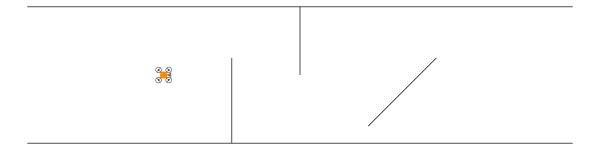

In [22]:
from navground.sim.notebook import display_in_notebook

display_in_notebook(exp.scenario.make_world())

In [23]:
run = exp.run_once(0)

In [24]:
run.get_records("sensing")

{'0/fov': <Dataset: shape (200, 1), dtype float64>,
 '0/range': <Dataset: shape (200, 360), dtype float64>,
 '0/start_angle': <Dataset: shape (200, 1), dtype float64>}

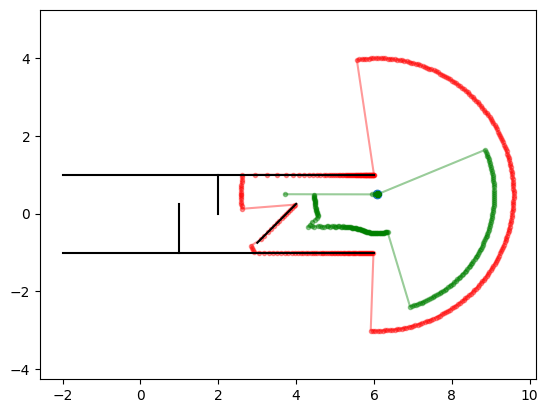

In [25]:
from matplotlib import pyplot as plt
from navground.sim.pyplot_helpers import plot_world

behavior = run.world.agents[0].behavior
state = behavior.environment_state

ranges = state.get_buffer('range').data
start = state.get_buffer('start_angle').data[0] + behavior.orientation
fov = state.get_buffer('fov').data[0]
angles = np.linspace(start, start + fov, len(ranges))
d_ranges = dilate_ranges(ranges, 0.5, fov)

ps = np.asarray([core.unit(angle) * r + behavior.position for angle, r in zip(angles, ranges)])
d_ps = np.asarray([core.unit(angle) * r + behavior.position for angle, r in zip(angles, d_ranges)])
c = behavior.position
ax = plt.subplot()
ax.plot(*c, 'o');
ax.plot(ps[:, 0], ps[:, 1], 'r.-', alpha=0.4)
ax.plot(d_ps[:, 0], d_ps[:, 1], 'g.-', alpha=0.4)
plot_world(ax, run.world)
plt.axis('equal');

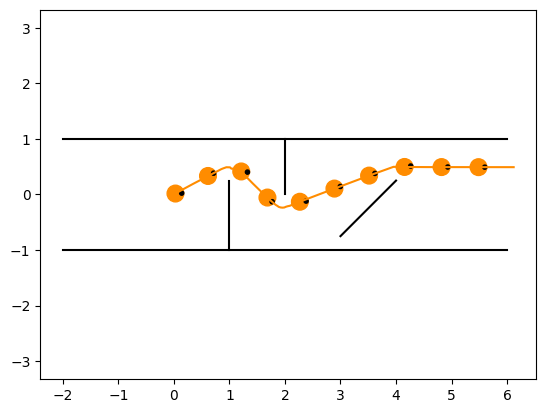

In [26]:
from matplotlib import pyplot as plt
from navground.sim.pyplot_helpers import plot_run

ax = plt.subplot()
plot_run(ax, run=run, step=20, with_agent=True)
plt.axis('equal');

In [27]:
display_video_from_run(run, factor=1, width=1280)

In [28]:
def render_scan(pose: core.Pose2, ranges: np.ndarray, start_angle: float, fov: float, color: str) -> str:
    a = start_angle + pose.orientation
    angles = np.linspace(a, a + fov, len(ranges))
    svg = ''
    ps = [core.unit(angle) * r + pose.position for angle, r in zip(angles, ranges)]
    points = " ".join([f"{x:.4f},{y:.4f}" for x, y in ps])
    return f'<polyline points="{points}" fill="none" stroke="{color}" stroke-width="0.05" stroke-opacity="0.2"/>'

def render_scan_state(pose: core.Pose2, state: core.SensingState, color: str) -> str:
    return render_scan(
        pose, state.get_buffer('range').data, 
        state.get_buffer('start_angle').data[0], 
        state.get_buffer('fov').data[0], color)

def scan_renderer(*args, **kwargs) -> str:
    def f(world: sim.World) -> str:
        return "\n".join(
            render_scan_state(agent.pose, agent.behavior.environment_state, *args, **kwargs) 
            for agent in world.agents)
    return f

In [29]:
display_video_from_run(run, factor=1, extras=[scan_renderer(color="red")], display_width=720, width=1280)

In [ ]:
record_video_from_run("../components/state_estimations/lidar.mp4", run, factor=1, 
                      width=1280, extras=[scan_renderer(color="red")])

## Local gridmap

In [35]:
import numpy as np

exp = sim.load_experiment(f"""
steps: 600
time_step: 0.033
record_pose: true
record_sensing:
  - agent_indices: [0]
scenario:
  walls:
   - line: [[-10, -6], [10, -6]]
   - line: [[-10, -6], [-10, 6]]
   - line: [[10, -6], [10, 6]]
   - line: [[-10, 6], [10, 6]]
   - line: [[-8, -4], [8, -4]]
   - line: [[-8, -4], [-8, 4]]
   - line: [[8, -4], [8, 4]]
   - line: [[-8, 4], [8, 4]]
   - line: [[-5, 6], [-6, 5.5]]
   - line: [[-6, 5.5], [-7, 6]]
  groups:
    - type: wheelchair
      color: darkorange
      number: 1
      radius: 0.25
      orientation: 3.14
      position: [0, 5]
      kinematics:
        type: 2WDiff
        max_speed: 1
        wheel_axis: 0.5
      behavior:
        type: Dummy
        environment: Sensing
      task:
        type: Path
        points: [[-9, -5], [9, -5], [9, 5], [-9, 5], [-9, -5]]
        tolerance: -1
      state_estimations:
        - type: Lidar
          name: lidar
          resolution: 1001
          range: 10
          start_angle: {-np.pi}
          field_of_view: {2 * np.pi}
          error_std_dev: 0.02
        - type: Odometry
          name: odom
        - type: LocalGridMap
          height: 300
          width: 300
          resolution: 0.02
          name: gridmap
          external_lidars: [lidar]
          external_odometry: odom
    - type: human
      color: red
      number: 5
      radius: 0.2
      orientation: 3.14
      position: [[8, -5], [5, -5], [2, -5], [-1, -5], [-4, -5]]
      kinematics:
        type: Ahead
        max_speed: 1
        max_angular_speed: 10.0
      behavior:
        type: HL
        horizon: 10
      task:
        type: Path
        points: [[-9, 5], [9, 5], [9, -5], [-9, -5], [-9, 5]]
        tolerance: -1
      state_estimation:
        type: Bounded
        range: 10
""")

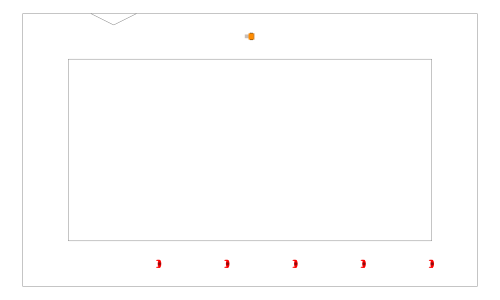

In [36]:
from navground.sim.notebook import display_in_notebook

display_in_notebook(exp.scenario.make_world(), width=500)

In [37]:
run = exp.run_once(0)

In [38]:
import moviepy as mpy
from navground.sim.ui.video import display_video_from_run, make_video_from_run
import numpy as np

def make_grid_map_video(run,
                        agent_index = 0,
                        name: str = '',
                        factor = 1,
                        period = 0.033):
    data = np.asarray(run.records[f'sensing/{agent_index}/{name}/local_gridmap'])
    images = data
    duration = len(data) * period / factor
    def make_frame(t: float):
        i = int(t / period * factor)
        i = np.clip(i, 0, len(images) - 1) 
        return np.repeat(images[i][::-1, :, np.newaxis], 3, axis=-1)
    return mpy.VideoClip(make_frame, duration=duration)


gridmap_clip = make_grid_map_video(run, 0, name='gridmap', factor=1)
world_clip = make_video_from_run(run, factor=1).resized((500, 300))
gridmap_clip.pos = lambda _: (500, 0)
img = mpy.ImageClip(np.full((300, 800, 3), 255, dtype=np.uint8), duration=0)
cc = mpy.CompositeVideoClip(clips=[img, world_clip, gridmap_clip])
cc.display_in_notebook(fps=30, width=800, rd_kwargs=dict(logger=None))

In [42]:
cc.write_videofile("../components/state_estimations/local_gridmap.mp4", fps=30, logger=None)